In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [17]:
measure_name = 'VUS_PR'
df = pd.read_csv('../../results/accuracy/all_accuracy_{}.csv'.format(measure_name))

In [69]:
# probs = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
# all_length = [16, 32, 64, 128, 256, 512, 768, 1024]

methods_conv = [
    'inception_time_{}',
    'convnet_{}',
    'resnet_{}',]

methods_sit = [
    'sit_conv_{}',
    'sit_linear_{}',
    'sit_stem_{}',
    'sit_stem_relu_{}',]

methods_ts = ['rocket_{}']

methods_feature = [
    'ada_boost_{}',
    'knn_{}',
    'decision_tree_{}',
    'random_forest_{}',
    'mlp_{}',
    'bayes_{}',
    'qda_{}',
    'svc_linear_{}']

all_methods_ens = [meth.format(length) for meth in methods_conv for length in all_length]
all_methods_ens += [meth.format(length) for meth in methods_sit for length in all_length]
all_methods_ens += [meth.format(length) for meth in methods_ts for length in all_length]
all_methods_ens += [meth.format(length) for meth in methods_feature for length in all_length]

old_method = ['IFOREST', 'LOF', 'MP', 'NORMA', 'IFOREST1', 'HBOS', 'OCSVM', 'PCA', 'AE', 'CNN', 'LSTM', 'POLY']

In [33]:
#Process Oracle results
def read_oracle_values(metric, type_o='true'):
    result = None
    
    for prob in probs:
        df = pd.read_csv(f"../../data/TSB/metrics/{type_o}_ORACLE-{prob}/{metric}.csv")
        df[['dataset', 'filename']] = df['Unnamed: 0'].str.split(pat='/', n=1, expand=True)
        df = df.drop(labels='Unnamed: 0', axis=1)
        
        if result is None:
            result = df.copy()
            result[f"{type_o}_ORACLE-{prob}"] = df[f"{type_o}_ORACLE-{prob}"]  
            if type_o != '':
                result = result.drop(labels=f"{type_o}_ORACLE-{prob}", axis=1)
            
        else:
            result[f"{type_o}_ORACLE-{prob}"] = df[f"{type_o}_ORACLE-{prob}"]   
    return result

df_true_oracle = read_oracle_values(metric=measure_name, type_o='TRUE')
df_lucky_oracle = read_oracle_values(metric=measure_name, type_o='LUCKY')
df_unlucky_oracle = read_oracle_values(metric=measure_name, type_o='UNLUCKY')
df_best2_oracle = read_oracle_values(metric=measure_name, type_o='BEST-2')
df_best3_oracle = read_oracle_values(metric=measure_name, type_o='BEST-3')

df_true_oracle = df_true_oracle.set_index(['filename'])
df_lucky_oracle = df_lucky_oracle.set_index(['filename'])
df_unlucky_oracle = df_unlucky_oracle.set_index(['filename'])
df_best2_oracle = df_best2_oracle.set_index(['filename'])
df_best3_oracle = df_best3_oracle.set_index(['filename'])

df_true_oracle = df_true_oracle.loc[df['filename']]
df_lucky_oracle = df_lucky_oracle.loc[df['filename']]
df_unlucky_oracle = df_unlucky_oracle.loc[df['filename']]
df_best2_oracle = df_best2_oracle.loc[df['filename']]
df_best3_oracle = df_best3_oracle.loc[df['filename']]

In [88]:
def plot_oracle_acc(df_oracle, df_tmp, style='--'):
    real_prob_list = []
    print(df_tmp)
    for prob in probs:
#         real_prob = float(len(df_tmp.loc[np.isclose(df_tmp['ORACLE'].round(6), df_oracle['ORACLE-{}'.format(int(prob))].round(6))])) / float(len(df_tmp))
#         real_prob = float(len(df_tmp.loc[np.isclose(df_tmp['ORACLE'].round(6), df_oracle['ORACLE-{}'.format(int(prob))].round(6))])) / float(len(df_tmp))
        real_prob_list.append(float(prob) / 100.0)
    sorted_vals = np.array([[x, y] for x, y in sorted(zip(real_prob_list, df_oracle.mean(numeric_only=False).values))])
    plt.plot(sorted_vals[:, 0], sorted_vals[:, 1], color='black', linestyle=style)
    return sorted_vals

def generate_Classification_Detection_graph(dataset=None, plot_curve=True): 
    if dataset is not None:
        df_tmp = df.loc[df['dataset'] == dataset]
        df_unlucky_oracle_tmp = df_unlucky_oracle.loc[df_unlucky_oracle['dataset'] == dataset]
        df_true_oracle_tmp = df_true_oracle.loc[df_true_oracle['dataset'] == dataset]
        df_lucky_oracle_tmp = df_lucky_oracle.loc[df_lucky_oracle['dataset'] == dataset]
        df_best2_oracle_tmp = df_best2_oracle.loc[df_best2_oracle['dataset'] == dataset]
        df_best3_oracle_tmp = df_best3_oracle.loc[df_best3_oracle['dataset'] == dataset]
    else:
        df_tmp = df
        df_unlucky_oracle_tmp = df_unlucky_oracle
        df_true_oracle_tmp = df_true_oracle
        df_lucky_oracle_tmp = df_lucky_oracle
        df_best2_oracle_tmp = df_best2_oracle
        df_best3_oracle_tmp = df_best3_oracle
        
    results, results_color, results_shape, results_name_leg = {}, {}, {}, {}
    for length in all_length:
        methods = [method.format(length) for method in all_methods_ens]
        tmp =  []
        colors = []
        shapes = []
        names_leg = []
        for method in methods:
            tmp.append([float(len(df_tmp.loc[df_tmp[method.format('_class')] == df_tmp['label']])) / float(len(df_tmp)), np.mean(df_tmp[method].values)])
            if method in [method.format(length) for method in methods_classical]:
                colors.append('green')
                shapes.append('^')
                names_leg.append('Feature-based')
            elif method in [method.format(length) for method in methods_sit]: 
                colors.append('red')
                shapes.append('s')
                names_leg.append('Transformer-based')
            elif method in [method.format(length) for method in methods_conv]: 
                colors.append('blue')
                shapes.append('o')
                names_leg.append('Convolutional-based')
            elif method in [method.format(length) for method in methods_ts]: 
                colors.append('black')
                shapes.append('x')
                names_leg.append('Rocket')
        results[length] = np.array(tmp)
        results_color[length] = colors 
        results_shape[length] = shapes 
        results_name_leg[length] = names_leg 
    
    label_done = []
    for length in all_length:
        for val_x, val_y, color, shape, name in zip(results[length][:, 0], results[length][:, 1], results_color[length], results_shape[length], results_name_leg[length]):
            if name in label_done:
                plt.scatter(val_x, val_y, facecolors=color, s=100, marker=shape)
            else:
                label_done.append(name)
                plt.scatter(val_x, val_y, facecolors=color, s=100, marker=shape, label=name)
            
    plt.xlabel('Classification accuracy')
    plt.ylabel('Anomaly Detection {}'.format(metric_name))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.axhline(df_tmp[old_method].mean(numeric_only=False).max(), c='red', linestyle='--')
    idx = np.argwhere(np.diff(np.sign(np.array([df_tmp[old_method].mean(numeric_only=False).max() for i in range(len(df_unlucky_oracle_tmp.mean(numeric_only=False).values))]) - df_unlucky_oracle_tmp.mean(numeric_only=False).values))).flatten()

    if not(plot_curve and (len(idx) > 0)):
        plt.axhline(df_tmp['ORACLE'].mean(), c='black', linestyle='-')
        plt.axhline(df_unlucky_oracle_tmp['ORACLE-0'].mean(), c='black', linestyle='-')
        plt.ylim(df_unlucky_oracle_tmp['ORACLE-0'].mean()-0.1, df_tmp['ORACLE'].mean() + 0.1)
    if plot_curve:
        _ = plot_oracle_acc(df_true_oracle_tmp, df_tmp, style='-')
        sorted_vals_luck = plot_oracle_acc(df_lucky_oracle_tmp, df_tmp)
        sorted_vals_unluck = plot_oracle_acc(df_unlucky_oracle_tmp, df_tmp)
        _ = plot_oracle_acc(df_best2_oracle_tmp, df_tmp, style='dotted')
        _ = plot_oracle_acc(df_best3_oracle_tmp, df_tmp, style='dotted')

        
        probfill = np.sort(np.concatenate([sorted_vals_luck[:, 0], sorted_vals_unluck[:, 0]]))
        y1fill = np.interp(probfill, sorted_vals_luck[:, 0], sorted_vals_luck[:, 1])
        y2fill = np.interp(probfill, sorted_vals_unluck[:, 0], sorted_vals_unluck[:, 1])
        plt.fill_between(probfill, y2fill, y1fill, where=y2fill < y1fill, interpolate=True, color='grey', alpha=0.2)

     Unnamed: 0                       filename  dataset     NORMA  IFOREST1  \
0             0        S01R02E0.test.csv@4.out  Daphnet  0.198065  0.055081   
1             1        S02R01E0.test.csv@3.out  Daphnet  0.266148  0.220559   
2             2        S03R01E1.test.csv@2.out  Daphnet  0.133152  0.443217   
3             3        S03R01E1.test.csv@4.out  Daphnet  0.133279  0.473794   
4             4        S03R01E1.test.csv@7.out  Daphnet  0.132663  0.426419   
..          ...                            ...      ...       ...       ...   
492         492  Yahoo_A2synthetic_79_data.out    YAHOO  0.384001  0.642029   
493         493   Yahoo_A2synthetic_7_data.out    YAHOO  0.005119  0.539482   
494         494  Yahoo_A2synthetic_89_data.out    YAHOO  0.297793  0.664473   
495         495  Yahoo_A2synthetic_91_data.out    YAHOO  0.023217  0.564564   
496         496  Yahoo_A2synthetic_93_data.out    YAHOO  0.003109  0.518293   

      IFOREST        MP      HBOS      POLY     OCS

/tmp/ipykernel_40410/532208536.py:73: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  idx = np.argwhere(np.diff(np.sign(np.array([df_tmp[old_method].mean().max() for i in range(len(df_unlucky_oracle_tmp.mean().values))]) - df_unlucky_oracle_tmp.mean().values))).flatten()
/tmp/ipykernel_40410/532208536.py:73: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  idx = np.argwhere(np.diff(np.sign(np.array([df_tmp[old_method].mean().max() for i in range(len(df_unlucky_oracle_tmp.mean().values))]) - df_unlucky_oracle_tmp.mean().values))).flatte

(0.0, 0.5)

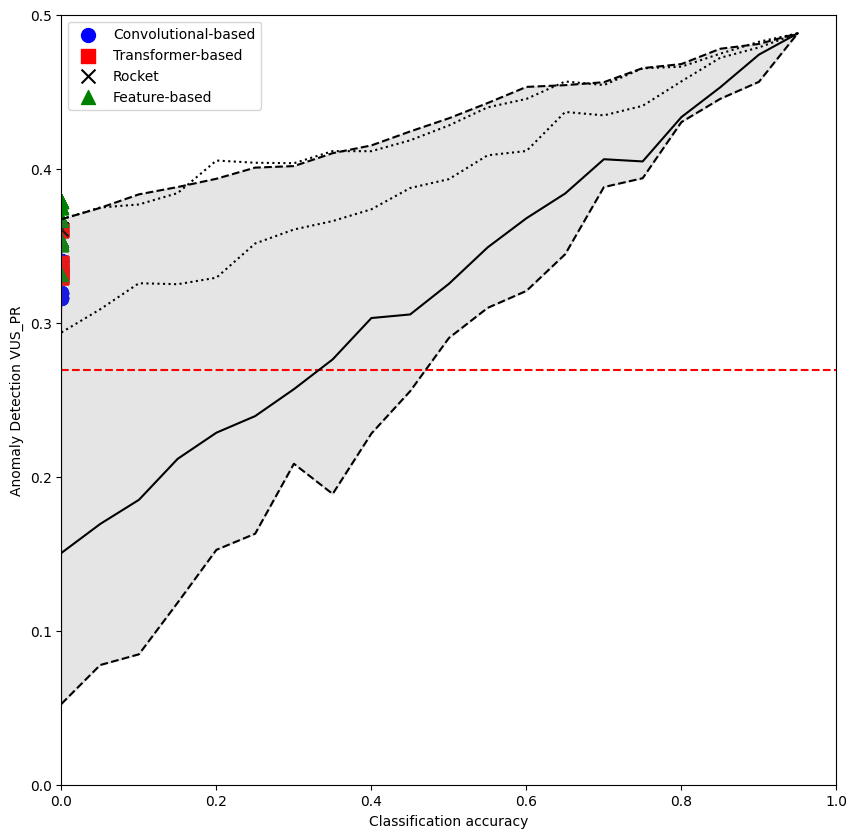

In [89]:
plt.figure(figsize=(10, 10))
generate_Classification_Detection_graph(dataset=None, plot_curve=True)
plt.ylim(0, 0.5)

     Unnamed: 0                         filename dataset     NORMA  IFOREST1  \
438         438  YahooA3Benchmark-TS100_data.out   YAHOO  0.526127  0.146451   
439         439   YahooA3Benchmark-TS10_data.out   YAHOO  0.454349  0.023916   
440         440   YahooA3Benchmark-TS13_data.out   YAHOO  0.387880  0.109169   
441         441    YahooA3Benchmark-TS1_data.out   YAHOO  0.268825  0.108564   
442         442   YahooA3Benchmark-TS21_data.out   YAHOO  0.394496  0.036693   
443         443   YahooA3Benchmark-TS23_data.out   YAHOO  0.363625  0.343427   
444         444   YahooA3Benchmark-TS24_data.out   YAHOO  0.537805  0.115438   
445         445   YahooA3Benchmark-TS28_data.out   YAHOO  0.851758  0.010932   
446         446    YahooA3Benchmark-TS2_data.out   YAHOO  0.403796  0.042723   
447         447   YahooA3Benchmark-TS34_data.out   YAHOO  0.928616  0.033879   
448         448   YahooA3Benchmark-TS35_data.out   YAHOO  0.580033  0.181971   
449         449   YahooA3Benchmark-TS36_

/tmp/ipykernel_40410/1946623969.py:64: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(val_x, val_y, facecolors=color, edgecolors='black', s=100, marker=shape, label=name)
/tmp/ipykernel_40410/1946623969.py:61: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(val_x, val_y, facecolors=color, edgecolors='black', s=100, marker=shape)
/tmp/ipykernel_40410/1946623969.py:72: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  idx = np.argwhere(np.diff(np.sign

KeyError: 'ORACLE'

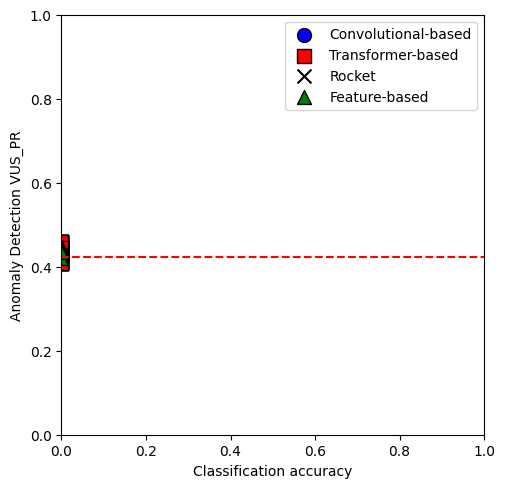

In [70]:
plt.figure(figsize=(12, 12))
for i, dataset in enumerate(['YAHOO','KDD21', 'OPPORTUNITY', 'SMD']):#,'GHL','SVDB']):
    plt.subplot(2, 2, i + 1)
    generate_Classification_Detection_graph(dataset=dataset, plot_curve=False)
    plt.title("{} dataset".format(dataset))
    plt.tight_layout()